In [1]:
from langchain_unstructured import UnstructuredLoader

loader = UnstructuredLoader(
    file_path="./example.pdf",
    strategy="hi_res",
)
docs = []
for doc in loader.lazy_load():
    docs.append(doc)

/Users/andreasimonecosta/mambaforge/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO: pikepdf C++ to Python logger bridge initialized
INFO: Reading PDF for file: ./example.pdf ...


In [2]:
docs

[Document(metadata={'source': './example.pdf', 'detection_class_prob': 0.47352278232574463, 'coordinates': {'points': ((60.067447662353516, 32.218318939208984), (60.067447662353516, 112.33258056640625), (367.9859924316406, 112.33258056640625), (367.9859924316406, 32.218318939208984)), 'system': 'PixelSpace', 'layout_width': 1653, 'layout_height': 2339}, 'last_modified': '2024-11-11T16:15:56', 'filetype': 'application/pdf', 'languages': ['eng'], 'page_number': 1, 'file_directory': '.', 'filename': 'example.pdf', 'category': 'Title', 'element_id': '0762eb0060587af7eb7783c4cab63c39'}, page_content='directa'),
 Document(metadata={'source': './example.pdf', 'detection_class_prob': 0.4335857331752777, 'coordinates': {'points': ((553.9447021484375, 616.9598999023438), (553.9447021484375, 655.2767944335938), (1103.5816650390625, 655.2767944335938), (1103.5816650390625, 616.9598999023438)), 'system': 'PixelSpace', 'layout_width': 1653, 'layout_height': 2339}, 'last_modified': '2024-11-11T16:15:

In [3]:
sett = set()

for doc in docs:
  sett.add(doc.metadata["category"])

print(sett)


{'Image', 'Title', 'Footer', 'NarrativeText', 'Table', 'UncategorizedText', 'Header', 'FigureCaption', 'ListItem'}


In [4]:
images = [doc for doc in docs if doc.metadata["category"] == "Table"]

images

[Document(metadata={'source': './example.pdf', 'detection_class_prob': 0.907008945941925, 'coordinates': {'points': ((146.81527709960938, 744.6967163085938), (146.81527709960938, 1296.931640625), (1493.4625244140625, 1296.931640625), (1493.4625244140625, 744.6967163085938)), 'system': 'PixelSpace', 'layout_width': 1653, 'layout_height': 2339}, 'last_modified': '2024-11-11T16:15:56', 'filetype': 'application/pdf', 'languages': ['eng'], 'page_number': 2, 'parent_id': '30c051b2e595ac4f9ce161a695e54150', 'file_directory': '.', 'filename': 'example.pdf', 'category': 'Table', 'element_id': '1a196d7575d89b97687ec7c82849ee1a'}, page_content="Sezione A Informazioni su Directa e i suoi servizi Pag 1 Sezione B Informazioni concernenti la salvaguardia degli investimenti finanziari e delle somme di de- Pag 3 naro della clientela Sezione C Informazioni sugli strumenti finanziari Pag 3 Sezione D Informazioni sugli oneri e sui costi Pag 10 Sezione E Informazioni per l'esecuzione e la trasmissione degl

How to properly embed the result of the OCR above? Are text embedding models enough? Even images have a `page_content` associated now.

In [5]:
import os
import getpass

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass()

In [5]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_ollama import OllamaEmbeddings
# from langchain_openai import OpenAIEmbeddings





# slower but embeddings seem to be better
embds = OllamaEmbeddings(model="snowflake-arctic-embed")
# embds = OpenAIEmbeddings()

supported_categories = set(["Image", "Table", "NarrativeText", "UncategorizedText"])

text_splitter = RecursiveCharacterTextSplitter(chunk_size=200, chunk_overlap=50)
splits = text_splitter.split_documents([doc for doc in docs if doc.metadata["category"] in supported_categories])
vectorstore = InMemoryVectorStore.from_documents(
    documents=splits, embedding=embds
)

retriever = vectorstore.as_retriever()

INFO: HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"


In [6]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama import ChatOllama
# from langchain_openai import ChatOpenAI

llm = ChatOllama(
  model="mistral-nemo"
)

# llm = ChatOpenAI(model="gpt-3.5-turbo")

system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)


question_answer_chain = create_stuff_documents_chain(llm, prompt)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)


/Users/andreasimonecosta/mambaforge/lib/python3.12/site-packages/langchain/chains/combine_documents/reduce.py:10: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from langchain.chains.combine_documents.base import BaseCombineDocumentsChain


In [11]:
results = rag_chain.invoke({"input": "Profilo semplice, a quanto ammontano sono le commissioni di trading su EXM?"})

results

INFO: HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO: HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


{'input': 'Profilo semplice, a quanto ammontano sono le commissioni di trading su EXM?',
 'context': [Document(id='86aefd51-db12-437a-9fa5-5eb4287b7248', metadata={'source': './example.pdf', 'detection_class_prob': 0.9303543567657471, 'coordinates': {'points': ((849.5230102539062, 1428.924072265625), (849.5230102539062, 1561.173583984375), (1554.9627685546875, 1561.173583984375), (1554.9627685546875, 1428.924072265625)), 'system': 'PixelSpace', 'layout_width': 1653, 'layout_height': 2339}, 'last_modified': '2024-11-11T16:15:56', 'filetype': 'application/pdf', 'languages': ['eng'], 'page_number': 17, 'parent_id': '1817014baf3a5aeda98403ca51e4d61c', 'file_directory': '.', 'filename': 'example.pdf', 'category': 'NarrativeText', 'element_id': 'fcf0806b97a115ce701832072f25b5e6'}, page_content="@ Manuale: interessi come da Tabella disponibile sul sito di trading (sezione INFO) + 0,1 per mille del controvalore all'apertura del prestito (calcolato sul prezzo di riferimento dei titoli al giorno

## Use of multimodal models

Many modern LLMs support inference over multimodal inputs (e.g., images). In some applications-- such as question-answering over PDFs with complex layouts, diagrams, or scans-- it may be advantageous to skip the PDF parsing, instead casting a PDF page to an image and passing it to a model directly. This allows a model to reason over the two dimensional content on the page, instead of a "one-dimensional" string representation.

In [12]:
import base64
import io

import fitz
from PIL import Image

def pdf_page_to_base64(pdf_path: str, page_number: int):
    pdf_document = fitz.open(pdf_path)
    page = pdf_document.load_page(page_number - 1)  # input is one-indexed
    pix = page.get_pixmap()
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    buffer = io.BytesIO()
    img.save(buffer, format="PNG")

    return base64.b64encode(buffer.getvalue()).decode("utf-8")

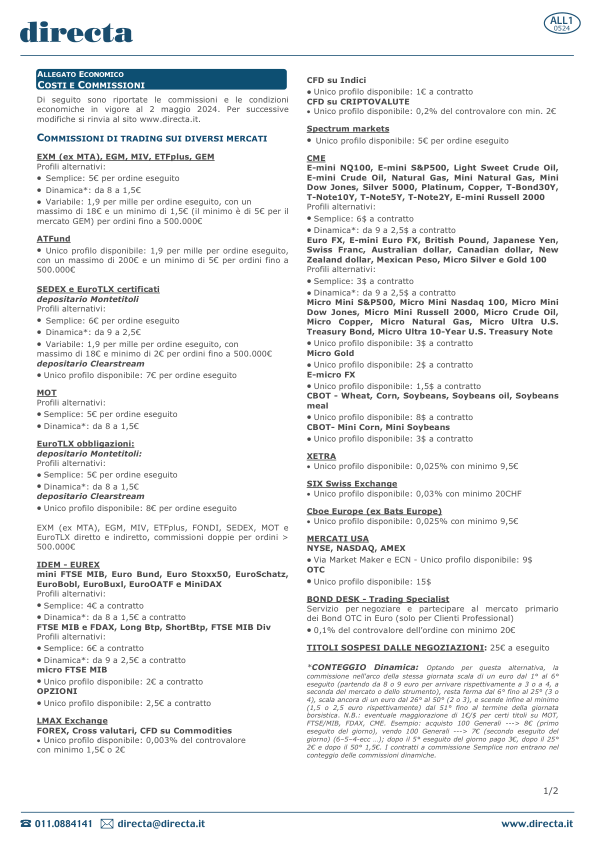

In [17]:
from IPython.display import Image as IPImage
from IPython.display import display

base64_image = pdf_page_to_base64("./example.pdf", 16)
display(IPImage(data=base64.b64decode(base64_image)))

In [15]:
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model="llama3.2-vision",
)

In [ ]:
from langchain_core.messages import HumanMessage

query = "Quali sono le commissioni di trading su EXM?"

message = HumanMessage(
    content=[
        {"type": "text", "text": query},
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
        },
    ],
)
response = llm.invoke([message])
print(response.content) # it took 1m 16.2s to run

INFO: HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Per i clienti del mercato italiano, la Commissione di Trading per l'EXM è pari a 5€ per ordine.
